In [1]:
import sys
sys.path.append("../..")
from synthetic import DataGenerator, SynthSettings, extract_lines_cc
from noise_designer import load_batches
import matplotlib.pyplot as plt
import random
import numpy as np
import cv2

In [2]:
pool = {i for i in range(5)}
level = random.choice(list(pool))
iterator = load_batches(level=0)

In [3]:
characters,scrolls,line_masks = next(iterator)
lines_img_0 = extract_lines_cc(img=scrolls[0],binary_mask=line_masks[0])
print(scrolls.shape)
print(line_masks.shape)
print(len(characters))

(5000, 338, 451)
(5000, 338, 451)
5000


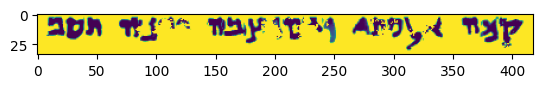

In [4]:
lines = extract_lines_cc(scrolls[0], line_masks[0])
line1 = lines[0]
plt.imshow(line1)

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np

def show_line_with_boxes_centers(line1, boxes):
 
    fig, ax = plt.subplots(figsize=(8,6))
    ax.imshow(line1, cmap='gray' if line1.ndim == 2 else None)

    center_xs = []

    # Draw bounding boxes and centre markers
    for (minr, minc, maxr, maxc) in boxes:
        # Bounding box
        rect = Rectangle(
            (minc, minr),
            maxc - minc,
            maxr - minr,
            edgecolor='blue',
            facecolor='none',
            linewidth=1,
        )
        ax.add_patch(rect)

        # Centre of the box
        cx = (minc + maxc) // 2
        cy = (minr + maxr) // 2
        center_xs.append(cx)
        ax.plot(cx, cy, marker='+', markersize=8, markeredgewidth=1.5,
                markeredgecolor='lime', markerfacecolor='none')

    ax.set_axis_off()
    plt.tight_layout()
    plt.show()

    return center_xs



In [108]:
from skimage import filters, measure, morphology

def segment_image(img, pad):

    gray = img.astype(float)
    blur = filters.gaussian(gray, sigma=1)
    thr = filters.threshold_otsu(blur)
    clean = morphology.remove_small_objects(blur < thr, min_size=30)
    lbls = measure.label(clean)
    raw_regions = measure.regionprops(lbls)

    regions = []
    for r in raw_regions:
        regions.append(r)

    boxes = []

    for r in regions:
        minr, minc, maxr, maxc = r.bbox[:4]
        minr = max(minr - pad, 0)
        minc = max(minc - pad, 0)
        maxr = min(maxr + pad, gray.shape[0])
        maxc = min(maxc + pad, gray.shape[1])
        boxes.append((minr, minc, maxr, maxc))

    return  boxes


boxes = segment_image(line1,pad=5)

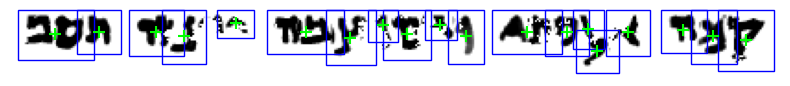

X-coordinates of centres: [24, 48, 79, 160, 202, 233, 280, 313, 365, 94, 184, 215, 247, 302, 335, 399, 122, 381, 318]


In [109]:
x_coords = show_line_with_boxes_contours_centers(line1, boxes)
print("X-coordinates of centres:", x_coords)

In [9]:
def extract_lines_segs_cc(
        img: np.ndarray,
        seg: np.ndarray,
        binary_mask: np.ndarray,
        min_area: int = 500,
        inflate: int = 6
    ) -> list[np.ndarray]:

    mask8 = (binary_mask > 0).astype(np.uint8) * 255

    n_labels, labels, stats, _ = cv2.connectedComponentsWithStats(
        mask8, connectivity=8)

    h, w = binary_mask.shape

    lines = []
    segs = []
    for lab in range(1, n_labels):
        x, y, bw, bh, area = stats[lab]
        if area < min_area:
            continue

        x0 = max(x - inflate, 0)
        y0 = max(y - inflate, 0)
        x1 = min(x + bw + inflate, w)
        y1 = min(y + bh + inflate, h)

        crop = img[y0:y1, x0:x1].copy()
        lines.append(crop)
        cs = seg[:, y0:y1, x0:x1].copy()
        segs.append(cs)

    return lines,segs

In [68]:
from noise import Noise

gen_settings = SynthSettings(
    downscale_factor=0.5,
    cutout_noise=True,
    cutout_noise_size=200,
    warp_noise=True,
    warp_noise_strength=5
)
noiser = Noise(gen_settings.downscale_size)
noiser.create_masks(3)
generator = DataGenerator(settings=gen_settings)
tokens, character_mask, scrolls, lines = generator.generate_passages_scrolls(2,skip_char_seg=False)
scrolls = noiser.damage(scrolls, strength=0.28)


In [69]:

print("Scrolls shape",scrolls.shape)
print("Lines shape",lines.shape)
print(len(tokens))
print("Character mask shape",character_mask.shape)
# 
lines_extracted, segs_extracted = extract_lines_segs_cc(scrolls[0],character_mask[0],lines[0])
print("Extracted lines shape",lines_extracted[0].shape)
print("Segmented mask shape",segs_extracted[0].shape)
print(lines_extracted[0].max())
segs_extracted[0].dtype

Scrolls shape (2, 338, 451)
Lines shape (2, 338, 451)
2
Character mask shape (2, 27, 338, 451)
Extracted lines shape (41, 413)
Segmented mask shape (27, 41, 413)
255


dtype('uint8')

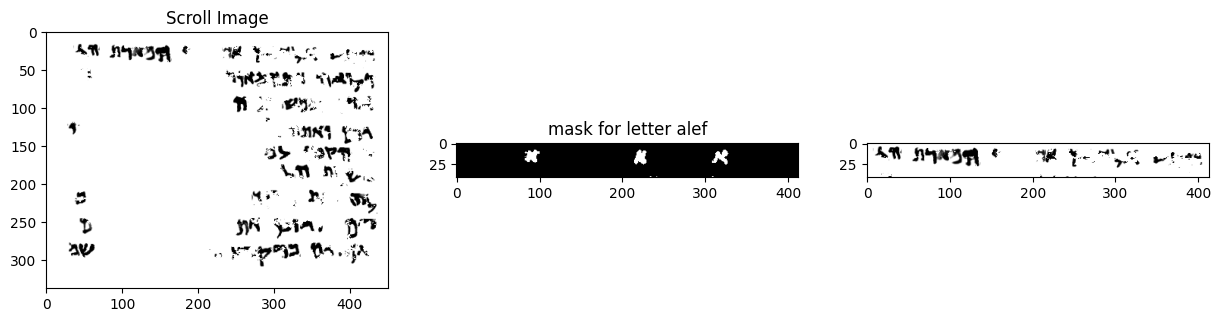

In [70]:

fig,ax = plt.subplots(1,3,figsize=(15,10))
ax[0].imshow(scrolls[0],cmap="gray")
ax[0].set_title("Scroll Image")
ax[1].imshow(segs_extracted[0][0], cmap="gray")
ax[1].set_title("mask for letter alef")
ax[2].imshow(lines_extracted[0], cmap="gray")

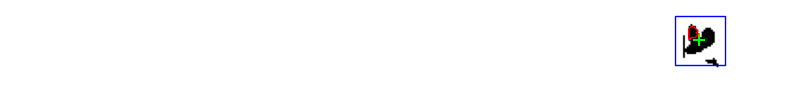

X-coordinates of centres: [369]


In [71]:
ctrs, boxes = segment_contours_and_boxes(
    255-segs_extracted[0][1],
    disk_radius=1,
    mgac_iter=200,
    smoothing=0,
    balloon=0.75,
    pad=5
)
x_coords = show_line_with_boxes_contours_centers(255-segs_extracted[0][1], ctrs, boxes)
print("X-coordinates of centres:", x_coords)

(27, 41, 413)
(41, 413)


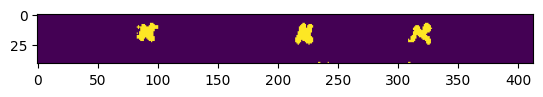

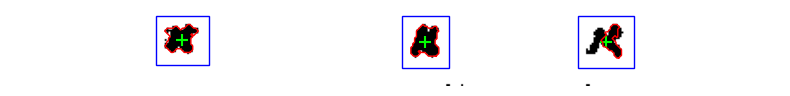

X-coordinates of channel 0 centres:[92, 222, 319]


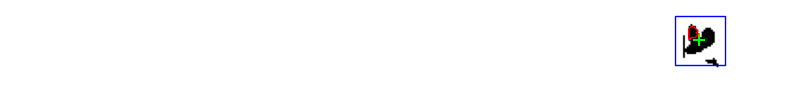

X-coordinates of channel 1 centres:[369]


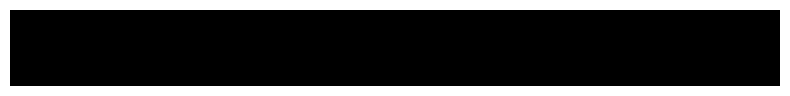

X-coordinates of channel 2 centres:[]


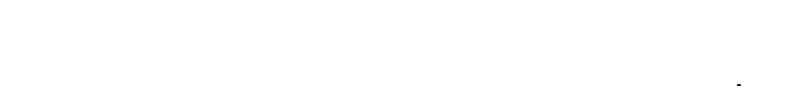

X-coordinates of channel 3 centres:[]


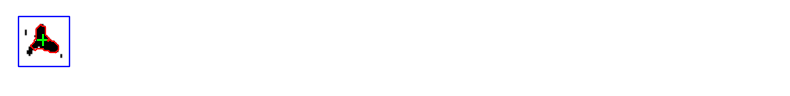

X-coordinates of channel 4 centres:[17]


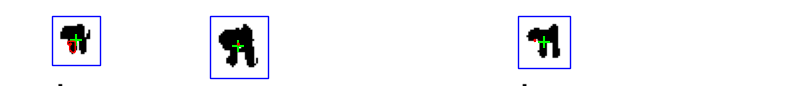

X-coordinates of channel 5 centres:[35, 122, 286]


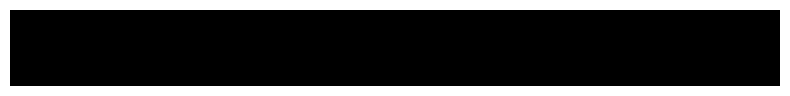

X-coordinates of channel 6 centres:[]


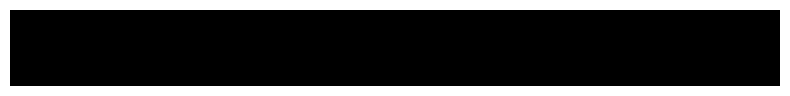

X-coordinates of channel 7 centres:[]


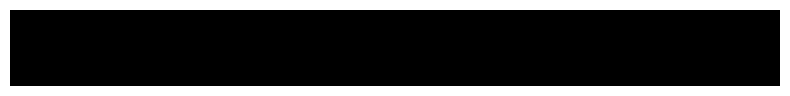

X-coordinates of channel 8 centres:[]


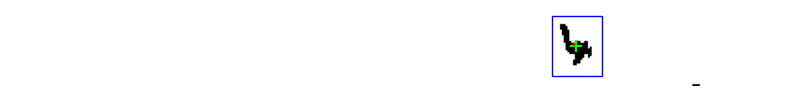

X-coordinates of channel 9 centres:[303]


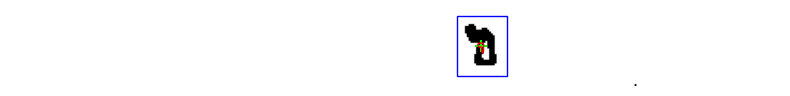

X-coordinates of channel 10 centres:[252]


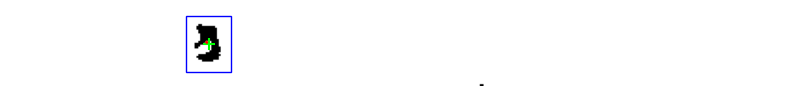

X-coordinates of channel 11 centres:[106]


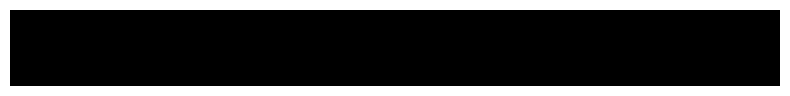

X-coordinates of channel 12 centres:[]


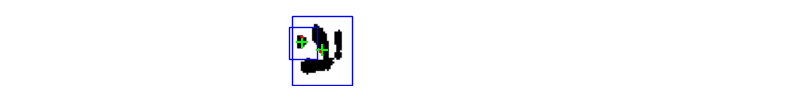

X-coordinates of channel 13 centres:[167, 156]


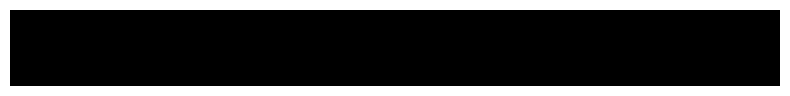

X-coordinates of channel 14 centres:[]


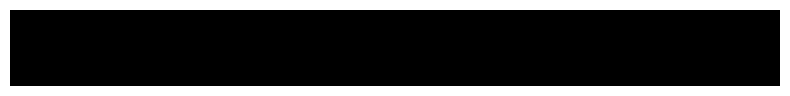

X-coordinates of channel 15 centres:[]


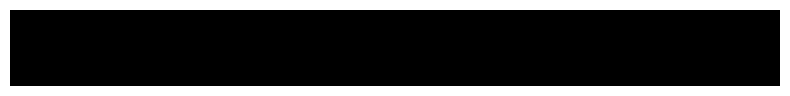

X-coordinates of channel 16 centres:[]


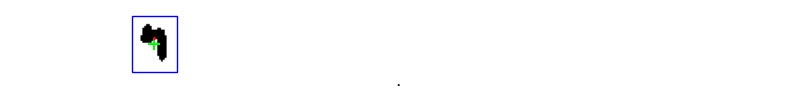

X-coordinates of channel 17 centres:[77]


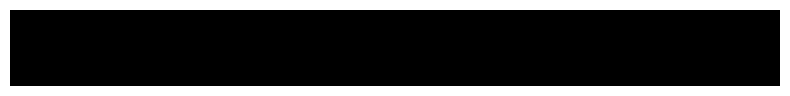

X-coordinates of channel 18 centres:[]


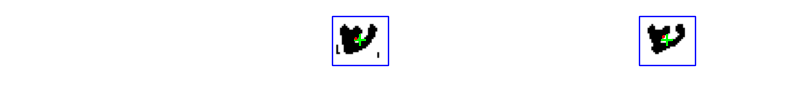

X-coordinates of channel 19 centres:[187, 352]


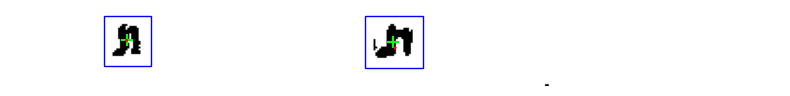

X-coordinates of channel 20 centres:[62, 205]


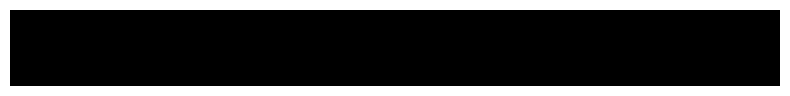

X-coordinates of channel 21 centres:[]


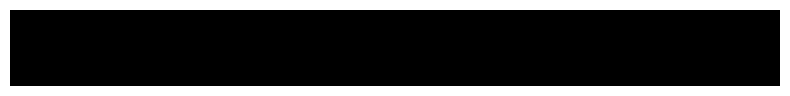

X-coordinates of channel 22 centres:[]


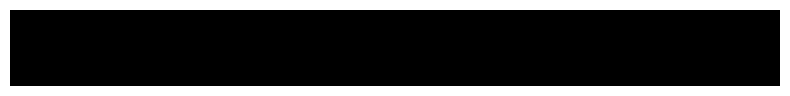

X-coordinates of channel 23 centres:[]


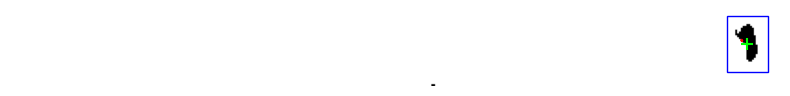

X-coordinates of channel 24 centres:[395]


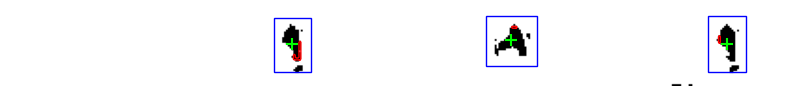

X-coordinates of channel 25 centres:[268, 384, 151]


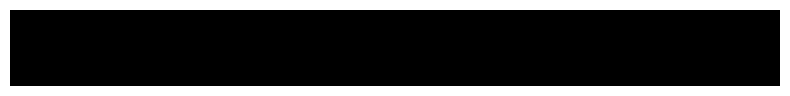

X-coordinates of channel 26 centres:[]


In [72]:
channels_line = segs_extracted[0]
print(channels_line.shape)
extracted_line = lines_extracted[0]
print(extracted_line.shape)
plt.imshow(channels_line[0])
character_coords = []
for index,channel in enumerate(channels_line):
    ctrs, boxes = segment_contours_and_boxes(
        255-channel,
        disk_radius=1,
        mgac_iter=200,
        smoothing=0,
        balloon=0.75,
        pad=5
    )
    x_coords = show_line_with_boxes_contours_centers(255-channel, ctrs, boxes)
    print(f"X-coordinates of channel {index} centres:{ x_coords}")
    for coord in x_coords:
        character_coords.append((coord,index))

[(395, 24), (384, 25), (369, 1), (352, 19), (319, 0), (303, 9), (286, 5), (268, 25), (252, 10), (222, 0), (205, 20), (187, 19), (167, 13), (156, 13), (151, 25), (122, 5), (106, 11), (92, 0), (77, 17), (62, 20), (35, 5), (17, 4)]
ויעשאלהיםאתשנניהמארתהג


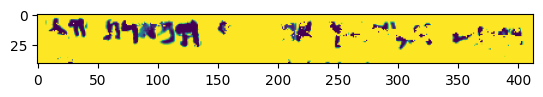

In [73]:
sorted_coords = sorted(character_coords,reverse=True, key=lambda x: x[0])
print(sorted_coords)
output = []
from alphabet import token_to_char
for _,token in sorted_coords:
    output.append(token_to_char[token])
print("".join(output))
plt.imshow(extracted_line)


In [74]:
print("".join(output))
tokens[0][0] == "".join(output)


ויעשאלהיםאתשנניהמארתהג


False